## Make AUROC / PRAUC - Rejection curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pickle
import torch
import torch.nn as nn

import sys
sys.path.append("../src/models")
from NN import SimpleBinaryClassificationNet

sys.path.append("../src/OODmetrics/")
from nn_posthoc import sample_estimator
from nn_posthoc import GEM_score, energy_ood_score

sys.path.append("../src/utils/")
from util import MakeRejectionDF
from util import plot_Rejection_curve
from util import rank_correlation

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
# load
X_train = torch.Tensor(np.load("../data/external/X_train.npy"))
y_train = torch.Tensor(np.load("../data/external/y_train.npy"))
X_test = torch.Tensor(np.load("../data/external/X_test.npy"))
y_test = torch.Tensor(np.load("../data/external/y_test.npy"))

SimpleNet = SimpleBinaryClassificationNet()
path_1 = "../src/models/weight/SimpleNet.pth"
SimpleNet.load_state_dict(torch.load(path_1))

<All keys matched successfully>

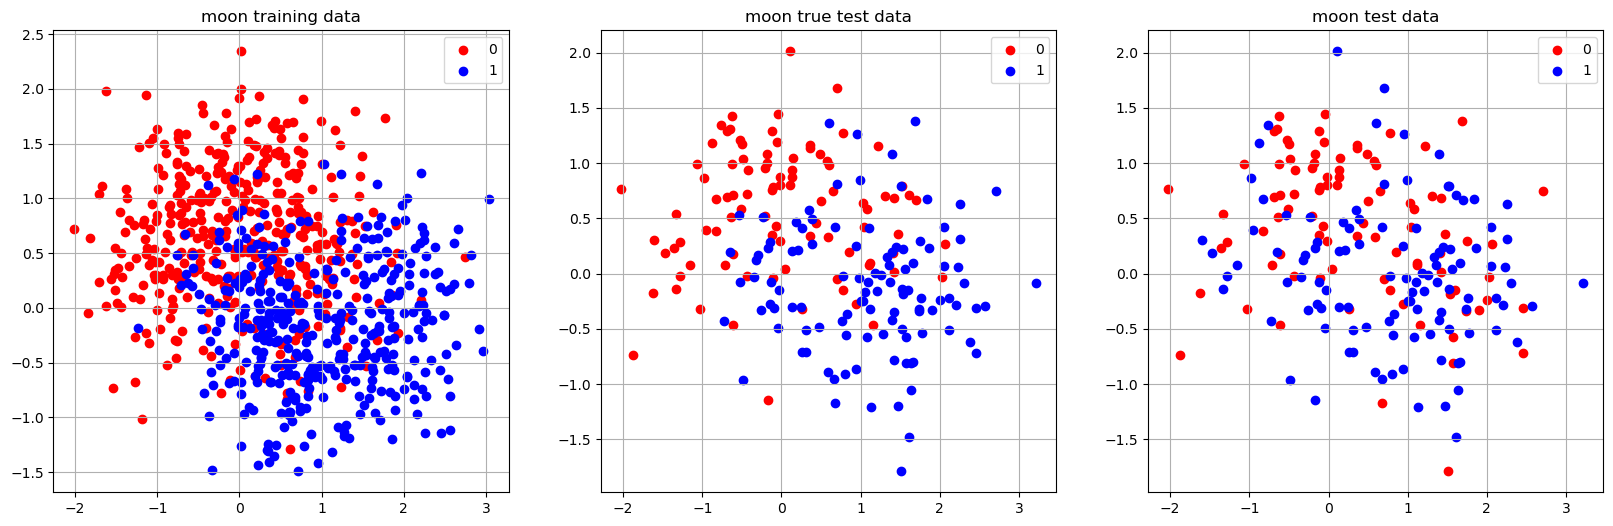

In [3]:
# visualize the data
X_train_0 = np.array(X_train)[y_train==0]
X_train_1 = np.array(X_train)[y_train==1]

# define out of test data and random perturbation
X_test_ = np.array(X_test)
y_test_ = np.array(y_test)
permuted_y_test = copy.deepcopy(y_test_)

out_of_condition_a = np.where((X_test[:,0] < -0.75) | (X_test[:,0] > 1.5),True,False)
out_of_condition_b = np.where((X_test[:,1] < -0.75) | (X_test[:,1] > 1.5),True,False)

np.random.seed(1)
out_of_y_test_a = np.random.permutation(y_test[out_of_condition_a])
out_of_y_test_b = np.random.permutation(y_test[out_of_condition_b])

permuted_y_test[out_of_condition_a] = out_of_y_test_a
permuted_y_test[out_of_condition_b] = out_of_y_test_b


X_test_0 = np.array(X_test)[permuted_y_test==0]
X_test_1 = np.array(X_test)[permuted_y_test==1]

true_X_test_0 = np.array(X_test)[y_test==0]
true_X_test_1 = np.array(X_test)[y_test==1]

fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
ax1.set_title("moon training data")
ax1.scatter(X_train_0[:,0], X_train_0[:,1], c='r', label='0')
ax1.scatter(X_train_1[:,0], X_train_1[:,1], c='b', label='1')
plt.legend()
plt.grid()

ax2 = fig.add_subplot(132)
ax2.set_title("moon true test data")
ax2.scatter(true_X_test_0[:,0], true_X_test_0[:,1], c='r', label='0')
ax2.scatter(true_X_test_1[:,0], true_X_test_1[:,1], c='b', label='1')
plt.legend()
plt.grid()

ax3 = fig.add_subplot(133)
ax3.set_title("moon test data")
ax3.scatter(X_test_0[:,0], X_test_0[:,1], c='r', label='0')
ax3.scatter(X_test_1[:,0], X_test_1[:,1], c='b', label='1')
plt.legend()
plt.grid()


In [4]:
SimpleNet.eval()
with torch.no_grad():
    test_pred_proba = torch.sigmoid(SimpleNet(X_test)).squeeze()
    test_pred_proba_array = np.array(test_pred_proba)
print(roc_auc_score(np.array(y_test),test_pred_proba_array,))
print(roc_auc_score(np.array(permuted_y_test),test_pred_proba_array,))

0.8939210950080514
0.7007070707070708


In [5]:
# for GEM score
mu_0,mu_1,precision_matrix = sample_estimator(X_train,y_train,SimpleNet)

test_GEM_Score_array = GEM_score(SimpleNet,mu_0,mu_1,precision_matrix.float(),X_test,0.5)
test_GEM_Score_array.shape

(200,)

In [6]:
# energy ood score
energy_ood_array = energy_ood_score(SimpleNet,X_test,1)
energy_ood_array.shape

(200,)

In [7]:
# DataFrame
df_test_ood = pd.DataFrame(np.hstack([np.array(X_test),test_pred_proba_array.reshape(200,1),
                                        np.array(permuted_y_test).reshape(200,1),test_GEM_Score_array.reshape(200,1),energy_ood_array.reshape(200,1)]),
                        columns=["x1","x2","pred_proba","permuted_y","GEM score","Energy score"])
df_test_ood

,x1,x2,pred_proba,permuted_y,GEM score,Energy score
0,0.674420,-1.173882,0.931451,0.0,5.964863,2.614596
1,0.254677,-0.709205,0.877103,1.0,5.900402,1.984725
2,-1.335464,0.544054,0.007683,0.0,6.225102,4.861068
3,-0.481832,1.039804,0.039958,0.0,5.988486,3.180889
4,-1.604644,0.304208,0.003145,1.0,6.387097,5.758687
...,...,...,...,...,...,...
195,0.108517,0.804697,0.188447,0.0,5.846075,1.512650
196,1.685194,1.381960,0.336625,0.0,5.817322,0.907495
197,0.987205,0.848374,0.172937,1.0,5.851689,1.607745
198,2.706740,0.745822,0.961682,0.0,6.042957,3.224347


In [8]:
Rejection_df_GEM = MakeRejectionDF(df_test_ood,"pred_proba","permuted_y","GEM score",1000)
Rejection_df_Energy = MakeRejectionDF(df_test_ood,"pred_proba","permuted_y","Energy score",1000)

In [9]:
Rejection_df_GEM

,thresh,num_id,num_ood,rejection_rate,AUROC_id,PRAUC_id
0,5.811269,1.0,199.0,99.5,NaN,NaN
1,5.812258,16.0,184.0,92.0,0.666667,0.641272
2,5.813247,19.0,181.0,90.5,0.666667,0.789630
3,5.814236,22.0,178.0,89.0,0.581197,0.615150
5,5.816215,25.0,175.0,87.5,0.590909,0.577419
...,...,...,...,...,...,...
464,6.270258,195.0,5.0,2.5,0.694019,0.677597
530,6.335545,196.0,4.0,2.0,0.697496,0.677597
536,6.341481,197.0,3.0,1.5,0.700271,0.692368
583,6.387973,198.0,2.0,1.0,0.693905,0.691114


In [10]:
print(Rejection_df_GEM.shape)
print(Rejection_df_Energy.shape)

(132, 6)
(155, 6)


Text(0.5, 1.0, 'AUROC-Rejection curve')

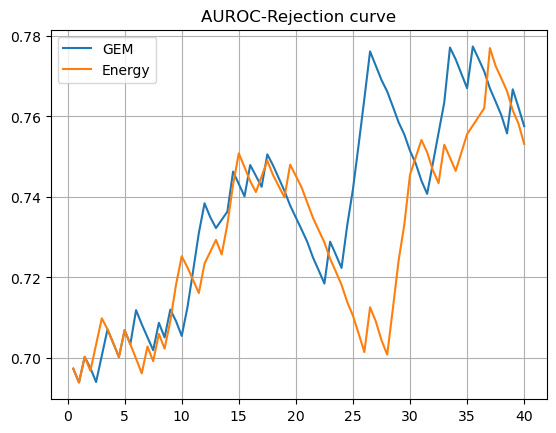

In [11]:
plt.figure()
plot_Rejection_curve(Rejection_df_GEM["rejection_rate"].values,Rejection_df_GEM["AUROC_id"].values, mask=40, label="GEM")
plot_Rejection_curve(Rejection_df_Energy["rejection_rate"].values,Rejection_df_Energy["AUROC_id"].values, mask=40, label="Energy")
plt.grid()
plt.legend()
plt.title("AUROC-Rejection curve")

Text(0.5, 1.0, 'PRAUC-Rejection curve')

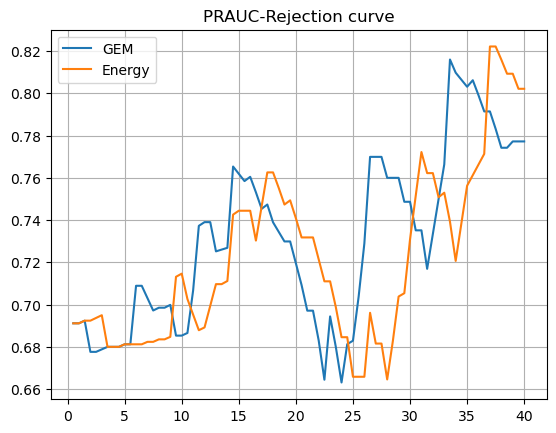

In [12]:
plt.figure()
plot_Rejection_curve(Rejection_df_GEM["rejection_rate"].values,Rejection_df_GEM["PRAUC_id"].values, mask=40, label="GEM")
plot_Rejection_curve(Rejection_df_Energy["rejection_rate"].values,Rejection_df_Energy["PRAUC_id"].values, mask=40, label="Energy")
plt.grid()
plt.legend()
plt.title("PRAUC-Rejection curve")

In [13]:
rank_correlation(Rejection_df_GEM["rejection_rate"].values,
                Rejection_df_GEM["AUROC_id"].values,
                "omit",
                "spearman",
                mask=40)

SpearmanrResult(correlation=0.8843729040912138, pvalue=1.5901262906758375e-24)

In [14]:
rank_correlation(Rejection_df_GEM["rejection_rate"].values,
                Rejection_df_GEM["AUROC_id"].values,
                "omit",
                "kendall",
                mask=40)

KendalltauResult(correlation=0.6853118712273644, pvalue=2.837616329265575e-17)